In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [3]:
df = pd.read_csv('../train_data_hand-gestures.csv')
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values
X.shape ,y.shape

((27455, 784), (27455,))

In [4]:
from sklearn.model_selection import train_test_split

num_classes = len(np.unique(y))

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#X_train = X_train.astype('float32') / 255.0
#X_val = X_val.astype('float32') / 255.0

X = X.reshape((-1, 28, 28, 1)).astype('float32')
#X_val = X_val.reshape((-1, 28, 28, 1)).astype('uint8')

# one-hot encoding
y = tf.keras.utils.to_categorical(y, num_classes+1)
#y_val = tf.keras.utils.to_categorical(y_val, num_classes+1)

X.shape ,y.shape

((27455, 28, 28, 1), (27455, 25))

In [5]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

def resize(image):
    img = array_to_img(image, scale=False)
    img = img.resize((32, 32))
    img = img.convert(mode='RGB')
    arr = img_to_array(img)
    return arr.astype(np.float64)

In [6]:
X_resized = [resize(img) for img in X]
X_resized = np.array(X_resized)
X_resized.shape

(27455, 32, 32, 3)

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = image_gen.flow(X_resized, y, batch_size=32, shuffle=True, subset='training')

valid_generator = image_gen.flow(X_resized, y, batch_size=32, shuffle=True, subset='validation')

(32, 32, 32, 3)
(32, 25)


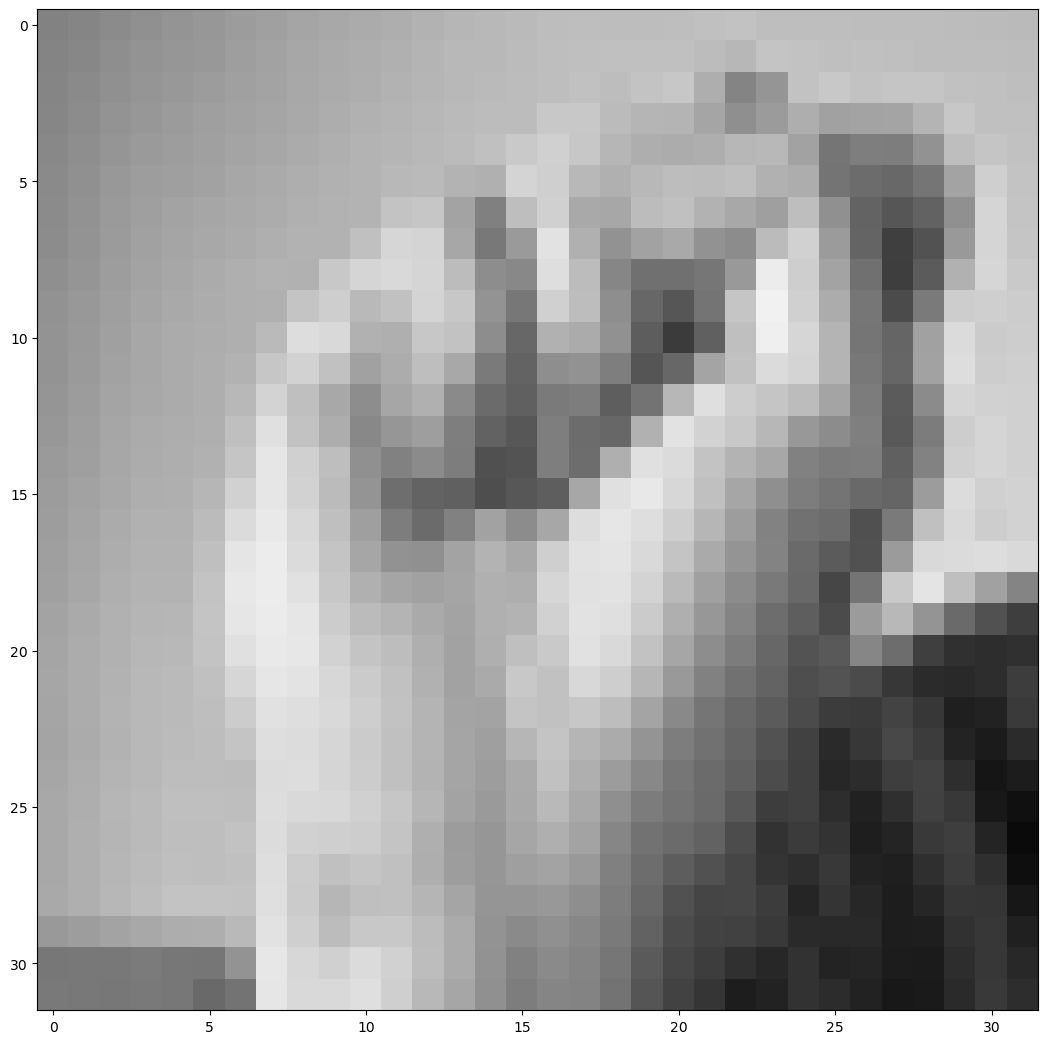

In [225]:
a, b = train_generator[0]
print(a.shape)
print(b.shape)
plt.imshow(a[0])
plt.savefig('resized', dpi=300, bbox_inches='tight')

In [9]:
from tensorflow.keras.applications.resnet50 import ResNet50
model = models.Sequential()

model.add(ResNet50(input_shape = (32, 32, 3), include_top = False, pooling = 'avg', weights = None))
model.load_weights('PreTrainedResNet50.weights.h5', skip_mismatch=True)
model.add(layers.Flatten())
model.add(Dense(25, activation = 'softmax'))

model.layers[0].trainable = False

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
history = model.fit(train_generator,epochs=50,validation_data=valid_generator, callbacks=[early_stopping])

Epoch 1/50


C:\Users\mahdi\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


687/687 ━━━━━━━━━━━━━━━━━━━━ 143s 186ms/step - accuracy: 0.3124 - loss: 2.3448 - val_accuracy: 0.5260 - val_loss: 1.5389
Epoch 2/50
687/687 ━━━━━━━━━━━━━━━━━━━━ 117s 170ms/step - accuracy: 0.5495 - loss: 1.4569 - val_accuracy: 0.6054 - val_loss: 1.2772
Epoch 3/50
687/687 ━━━━━━━━━━━━━━━━━━━━ 117s 170ms/step - accuracy: 0.6219 - loss: 1.2294 - val_accuracy: 0.6634 - val_loss: 1.1045
Epoch 4/50
687/687 ━━━━━━━━━━━━━━━━━━━━ 118s 171ms/step - accuracy: 0.6730 - loss: 1.0595 - val_accuracy: 0.6773 - val_loss: 1.0370
Epoch 5/50
687/687 ━━━━━━━━━━━━━━━━━━━━ 117s 170ms/step - accuracy: 0.7040 - loss: 0.9712 - val_accuracy: 0.7175 - val_loss: 0.9341
Epoch 6/50
687/687 ━━━━━━━━━━━━━━━━━━━━ 117s 170ms/step - accuracy: 0.7345 - loss: 0.8743 - val_accuracy: 0.7283 - val_loss: 0.8728
Epoch 7/50
687/687 ━━━━━━━━━━━━━━━━━━━━ 116s 169ms/step - accuracy: 0.7545 - loss: 0.8082 - val_accuracy: 0.7150 - val_loss: 0.8647
Epoch 8/50
687/687 ━━━━━━━━━━━━━━━━━━━━ 137s 199ms/step - accuracy: 0.7705 - loss: 0.75

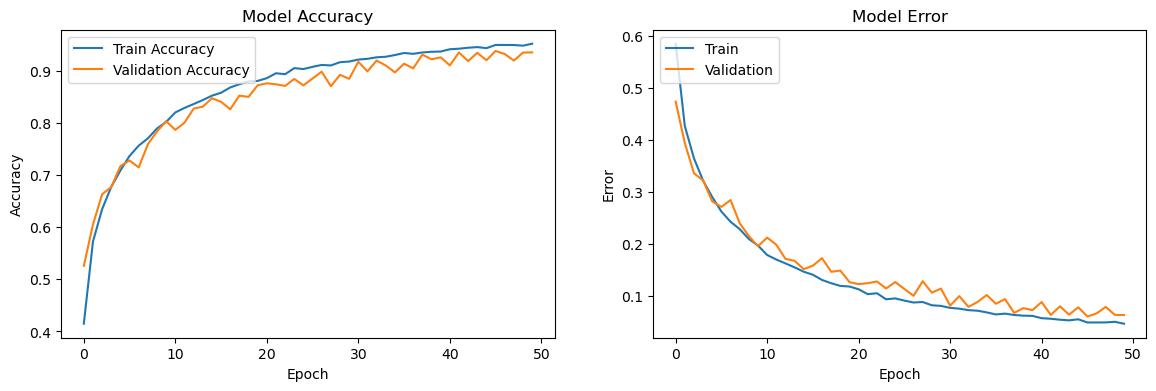

In [11]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

train_error = 1 - np.array(history.history['accuracy'])
val_error = 1 - np.array(history.history['val_accuracy'])

plt.subplot(1, 2, 2)
plt.plot(train_error, label='Train Error')
plt.plot(val_error, label='Validation Error')
plt.title('Model Error')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.savefig('tl', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
df_test = pd.read_csv('../test_data_hand-gestures.csv')
X_test = df_test.iloc[:, 1:].values
y_test = df_test.iloc[:, 0].values

X_test = X_test.reshape((-1, 28, 28, 1)).astype('uint8')
X_test_resized = [resize(img) for img in X_test]
X_test_resized = np.array(X_test_resized)
print(X_test_resized.shape)
y_test = tf.keras.utils.to_categorical(y_test, num_classes+1)

(7172, 32, 32, 3)


In [215]:
image_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_generator = image_gen.flow(X_test_resized, y_test, batch_size=32, shuffle=True, subset='training')

In [20]:
test_loss, test_accuracy = model.evaluate(test_generator)

  1/180 ━━━━━━━━━━━━━━━━━━━━ 47s 266ms/step - accuracy: 0.7812 - loss: 0.7102

C:\Users\mahdi\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


180/180 ━━━━━━━━━━━━━━━━━━━━ 29s 161ms/step - accuracy: 0.7532 - loss: 0.8400


[21 24 16  6  4 15 24 18 24 19  5 17 14 10 10 17 19  1 13  1 21  6  3  6
  2  5  1 18  4 15]
179/179 ━━━━━━━━━━━━━━━━━━━━ 25s 138ms/step


<Figure size 1300x1300 with 0 Axes>

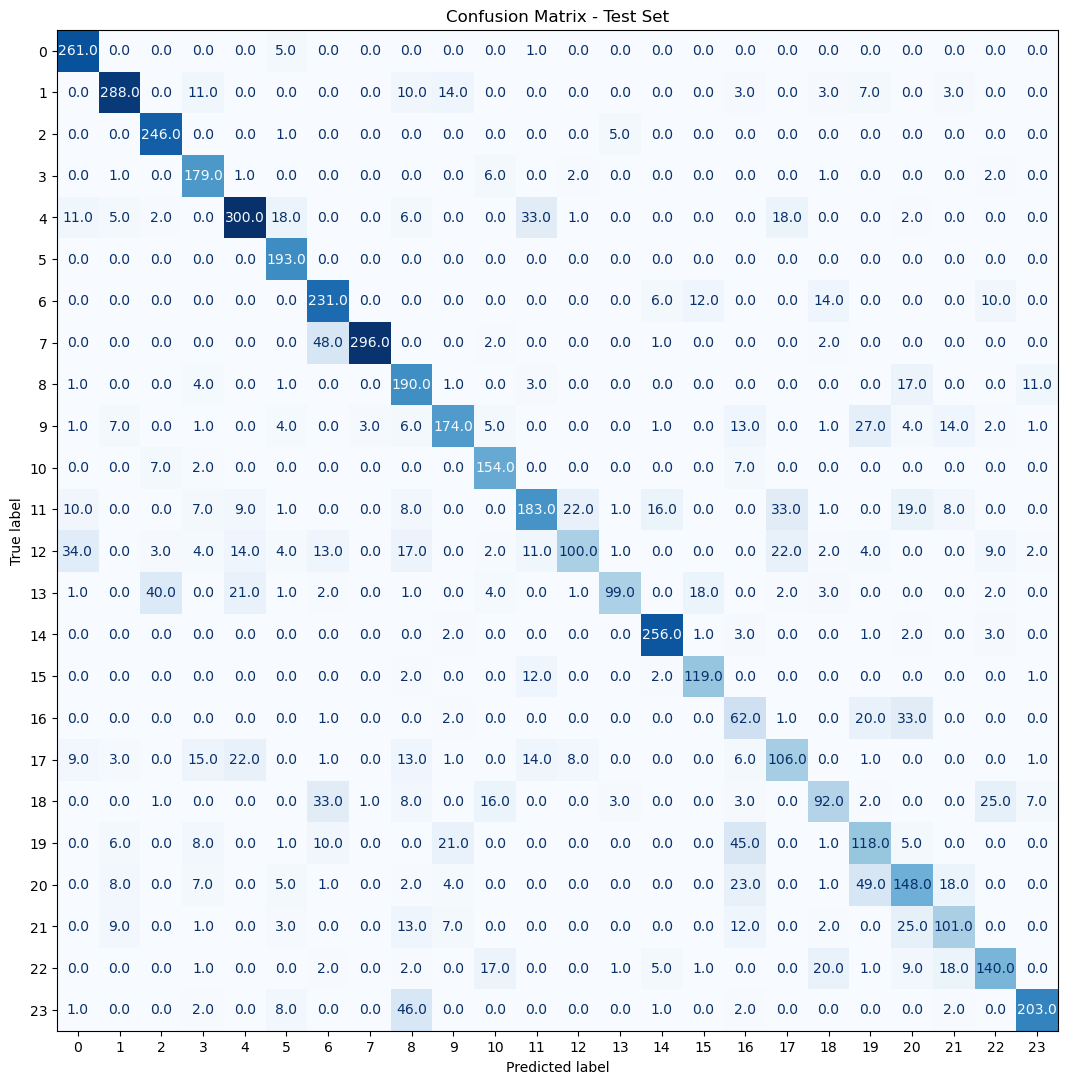

<Figure size 1300x1300 with 0 Axes>

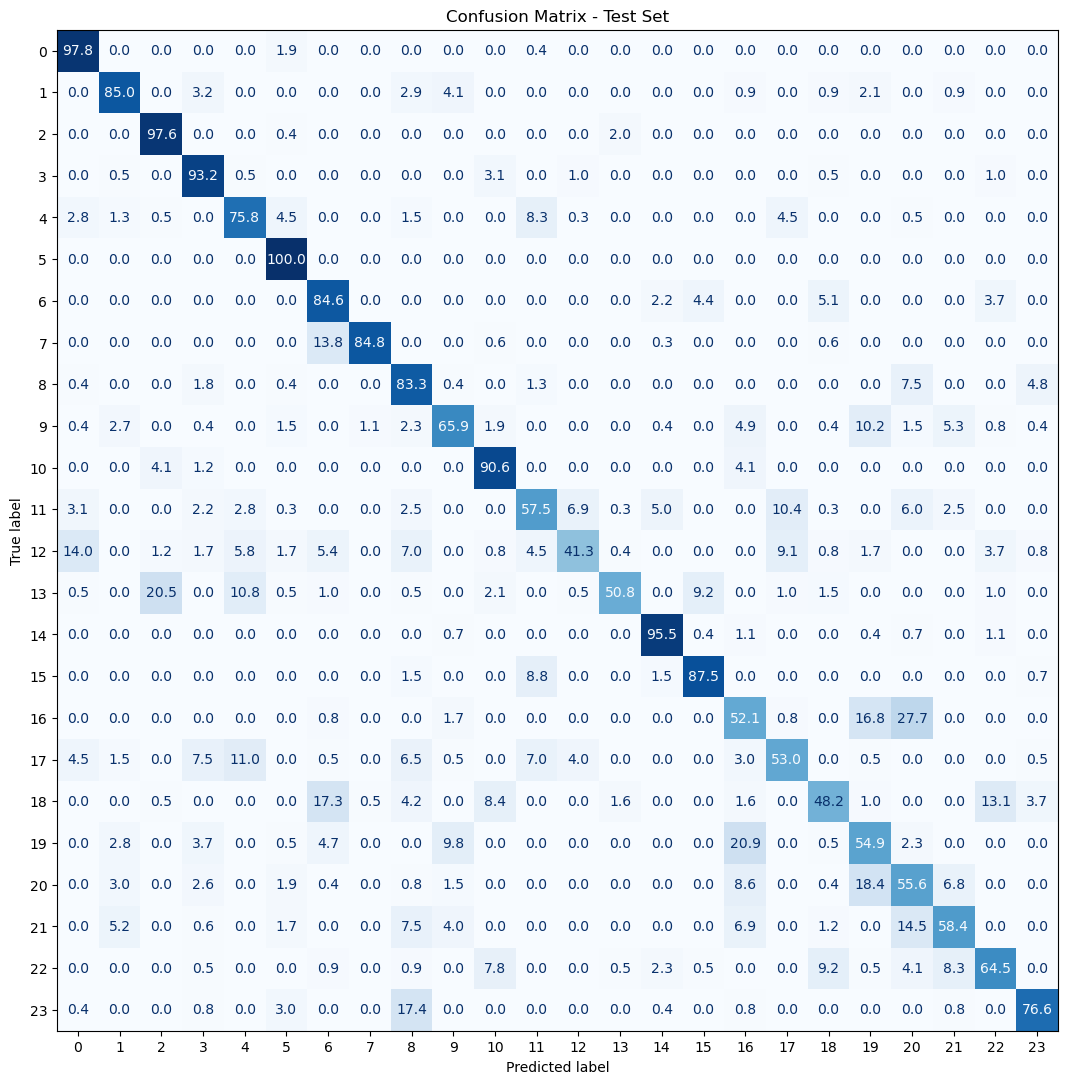

In [223]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
test_generator.reset()
steps = test_generator.n // test_generator.batch_size
y_true = []
for i in range(steps):
    _, labels = next(test_generator)
    y_true.extend(labels)
y_true = np.array(y_true)
y_true = np.argmax(y_true, axis=1)
print(y_true[0:30])

test_generator.reset()  # Reset the generator to start from the beginning
y_pred = model.predict(test_generator, steps=steps)

y_test_pred_classes = np.argmax(y_pred, axis=1)
# y_test_argmax = np.argmax(all_labels, axis=1)

cm_test = confusion_matrix(y_true, y_test_pred_classes)
cm_test_percent = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis] * 100

plt.figure()
plt.rcParams['figure.figsize'] = [13, 13]
disp_test = ConfusionMatrixDisplay(cm_test, display_labels=np.arange(24))
disp_test.plot(cmap=plt.cm.Blues,colorbar=False , values_format='.1f')
plt.title('Confusion Matrix - Test Set')
plt.savefig('tl cm', dpi=300, bbox_inches='tight')
plt.show()

plt.figure()
plt.rcParams['figure.figsize'] = [13, 13]
disp_test = ConfusionMatrixDisplay(cm_test_percent, display_labels=np.arange(24))
disp_test.plot(cmap=plt.cm.Blues,colorbar=False , values_format='.1f')
plt.title('Confusion Matrix - Test Set')
plt.show()